## Keypoint Detecton- GradCam

In this blog, I am showing, how can we ensure , if our model is truly learning features from the image. For this , I am using - a bit modified- *** GradCam ***

### Gradcam for dummies- like me 

For people like me , In simple terms, Gradcam is some lines of codes to show which features or parts of the images **activates** to a particular layer when you feed into it. The most famouse example is this following image

![gcam_cat](newgcam_heatmap_overlaid_283_cat_dog.png)

Here the image shows, the parts of the image, which gets activated when it classifies "cat". [link](https://arxiv.org/abs/1610.02391)

### Ok, lets get it done!

In [ ]:
import copy
import os.path as osp

import click
import cv2
import matplotlib.cm as cm
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import models, transforms

from grad_cam import (
    GradCAM,
    GuidedBackPropagation
)


In [6]:
import IPython

In [7]:
def imshow(img):
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)

In [8]:

def get_device(cuda):
    cuda = cuda and torch.cuda.is_available()
    device = torch.device("cuda" if cuda else "cpu")
    if cuda:
        current_device = torch.cuda.current_device()
        print("Device:", torch.cuda.get_device_name(current_device))
    else:
        print("Device: CPU")
    return device

In [9]:
def load_images(image_paths):
    images = []
    raw_images = []
    print("Images:")
    for i, image_path in enumerate(image_paths):
        print("\t#{}: {}".format(i, image_path))
        image, raw_image = preprocess(image_path)
        images.append(image)
        raw_images.append(raw_image)
    return images, raw_images


In [10]:
def get_classtable():
    classes = []
    with open("samples/synset_words.txt") as lines:
        for line in lines:
            line = line.strip().split(" ", 1)[1]
            line = line.split(", ", 1)[0].replace(" ", "_")
            classes.append(line)
    return classes

In [11]:
def preprocess(image_path):
    raw_image = cv2.imread(image_path)
    raw_image = cv2.resize(raw_image, (9))
    image = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )(raw_image[..., ::-1].copy())
    return image, raw_image

In [30]:
def save_gradient(filename, gradient):
    gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
    imshow(gradient)
    cv2.imwrite(filename, np.uint8(gradient))


def save_gradcam(filename, gcam, raw_image, paper_cmap=False):
    gcam = gcam.cpu().numpy()
    cmap = cm.jet_r(gcam)[..., :3] * 255.0
    if paper_cmap:
        alpha = gcam[..., None]
        gcam = alpha * cmap + (1 - alpha) * raw_image
    else:
        gcam = (cmap.astype(np.float) + raw_image.astype(np.float)) / 2
    imshow(gcam)
    cv2.imwrite(filename, np.uint8(gcam))


def save_sensitivity(filename, maps):
    maps = maps.cpu().numpy()
    scale = max(maps[maps > 0].max(), -maps[maps <= 0].min())
    maps = maps / scale * 0.5
    maps += 0.5
    maps = cm.bwr_r(maps)[..., :3]
    maps = np.uint8(maps * 255.0)
    maps = cv2.resize(maps, (224, 224), interpolation=cv2.INTER_NEAREST)
    cv2.imwrite(filename, maps)
    imshow(maps)



In [31]:
cuda=True

In [32]:
image_paths=["../image.npy"]

In [33]:
topk=1

In [34]:
output_dir="output_dir/"

In [35]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [36]:
class SezanNet(nn.Module):
    def __init__(self):
        super(SezanNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(4, 4),stride=2) ## 32x47x47
        self.dropout=nn.Dropout()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4, 4),stride=2) # 64x22x22
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),stride=2) # 128x10x10
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(1,1),stride=2) # 256x5x5
        
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(in_features=256*5*5,out_features=30)
        
    def forward(self,x):
        x = self.dropout(self.relu(self.conv1(x)))
        x = self.dropout(self.relu(self.conv2(x)))
        x = self.dropout(self.relu(self.conv3(x)))
        x = self.dropout(self.relu(self.conv4(x)))
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        return x
        

In [37]:
model=SezanNet()

In [38]:
model.load_state_dict(torch.load("../network_state_dict.pkl"))

In [39]:
raw_image = np.load("../image.npy")

In [40]:
image=raw_image.copy()

In [41]:
image = image.reshape(-1,96,96)

In [42]:
image.shape

(1, 96, 96)

In [43]:
images = torch.from_numpy(image)

In [44]:
images

tensor([[[142., 142., 142.,  ...,  24.,  24.,  24.],
         [142., 142., 142.,  ...,  24.,  24.,  24.],
         [143., 142., 142.,  ...,  24.,  24.,  23.],
         ...,
         [128., 127., 128.,  ...,  66.,  63.,  60.],
         [128., 127., 128.,  ...,  64.,  61.,  58.],
         [127., 128., 128.,  ...,  62.,  60.,  58.]]], dtype=torch.float64)

In [45]:
images=images.reshape(-1,1,96,96)

In [46]:
images = images/255

In [47]:
images

tensor([[[[0.5569, 0.5569, 0.5569,  ..., 0.0941, 0.0941, 0.0941],
          [0.5569, 0.5569, 0.5569,  ..., 0.0941, 0.0941, 0.0941],
          [0.5608, 0.5569, 0.5569,  ..., 0.0941, 0.0941, 0.0902],
          ...,
          [0.5020, 0.4980, 0.5020,  ..., 0.2588, 0.2471, 0.2353],
          [0.5020, 0.4980, 0.5020,  ..., 0.2510, 0.2392, 0.2275],
          [0.4980, 0.5020, 0.5020,  ..., 0.2431, 0.2353, 0.2275]]]],
       dtype=torch.float64)

In [48]:
images=images.float()

In [49]:
"""
Common usage:
1. Wrap your model with visualization classes defined in grad_cam.py
2. Run forward() with images
3. Run backward() with a list of specific classes
4. Run generate() to export results
"""

# =========================================================================
print("Vanilla Backpropagation:")

bp = BackPropagation(model=model)
keypoints = bp.forward(images)  # sorted

Vanilla Backpropagation:


In [50]:
keypoints

tensor([[ 0.3991, -0.1617, -0.3830, -0.2123,  0.2350, -0.2453,  0.5630, -0.2603,
         -0.2257, -0.1832, -0.5584, -0.1751,  0.1013, -0.3660,  0.7163, -0.4049,
         -0.2087, -0.3082, -0.7137, -0.2871, -0.0958,  0.3878,  0.4939,  0.5568,
         -0.3131,  0.6424,  0.0499,  0.6254, -0.0738,  0.7241]],
       grad_fn=<ThAddmmBackward>)

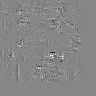

In [51]:
for i in range(topk):
    bp.backward(ids=keypoints)
    gradients = bp.generate()

    # Save results as image files
    for j in range(len(images)):
        
        save_gradient(
            filename=osp.join(
                output_dir,
                "{}-{}.png".format(j,i)
            ),
            gradient=gradients[j],
        )

# Remove all the hook function in the "model"
bp.remove_hook()

In [52]:
for name,module in model.named_modules():
    print(name)


conv1
dropout
conv2
conv3
conv4
relu
fc1


In [53]:
target_layer="conv1"

Grad-CAM/Guided Backpropagation/Guided Grad-CAM:


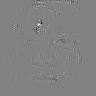

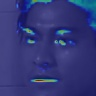

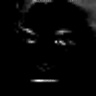

In [54]:
print("Grad-CAM/Guided Backpropagation/Guided Grad-CAM:")

gcam = GradCAM(model=model)
_ = gcam.forward(images)

gbp = GuidedBackPropagation(model=model)
_ = gbp.forward(images)

for i in range(topk):
    # Guided Backpropagation
    gbp.backward(keypoints)
    gradients = gbp.generate()

    # Grad-CAM
    gcam.backward(keypoints)
    regions = gcam.generate(target_layer=target_layer)

    for j in range(len(images)):
        

        # Guided Backpropagation
        save_gradient(
            filename=osp.join(
                output_dir,
                "{}-{}-guided.png".format(j,i),
            ),
            gradient=gradients[j],
        )

        # Grad-CAM
        save_gradcam(
            filename=osp.join(
                output_dir,
                "{}-{}-gradcam.png".format(
                    j, i                ),
            ),
            gcam=regions[j, 0],
            raw_image=raw_image
        )

        # Guided Grad-CAM
        save_gradient(
            filename=osp.join(
                output_dir,
                "{}-{}-guided_gradcam.png".format(
                    j,i
                ),
            ),
            gradient=torch.mul(regions, gradients)[j],
        )
